<a>
  <img src='cnn-portada.jpg' width="1150">
</a>


Agradecimientos a Zalando por la laboriosa tarea de crear este conjunto de datos de 70.000 imágenes usado para este modelo. <br>


In [1]:
# Importamos librerías necesarias

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflowjs as tfjs
import math
import keras
import matplotlib.pyplot as plt


In [5]:
# En la librería de tensorflow_datasets podemos encontrar el dataset
data, metadata = tfds.load("fashion_mnist", as_supervised= True, with_info=True)

In [6]:
# Obtenemos la información general de este dataset
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\sjfer\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
  

In [7]:
# Separamos los datos en entrenamiento y prueba
data_train, data_test = data['train'], data['test']

In [8]:
#Los metadatos además traen los nombres de las categorías que hay en el set.
#Mostramos las etiquetas de las 10 categorias posibles
nombres_clases = metadata.features['label'].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## TRAIN/ TEST

In [9]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1) (255 por ser los valores de los píxeles)
#Hace que la red aprenda mejor y mas rapido
def normalizar(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255 
  return images, labels

#Normalizamos
data_train = data_train.map(normalizar)
data_test = data_test.map(normalizar)

#Agregamos a a caché. Esto sirve para que el entrenamiento sea más rápido. 
datos_entrenamiento = data_train.cache()
datos_pruebas = data_test.cache()

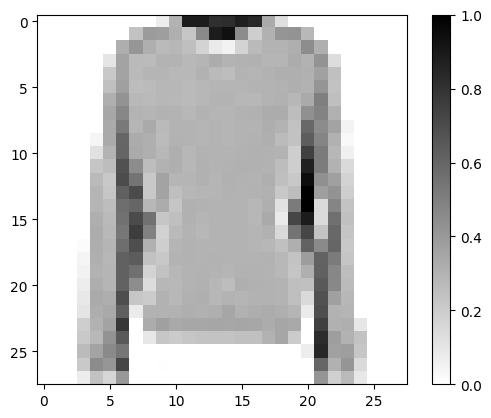

In [10]:
# Hacemos una prueba mostrando una imagen. Por ejemplo la primera.
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
# Redimensionamos
imagen = imagen.numpy().reshape((28,28)) 



# Graficamos la imagen con matplotlib
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

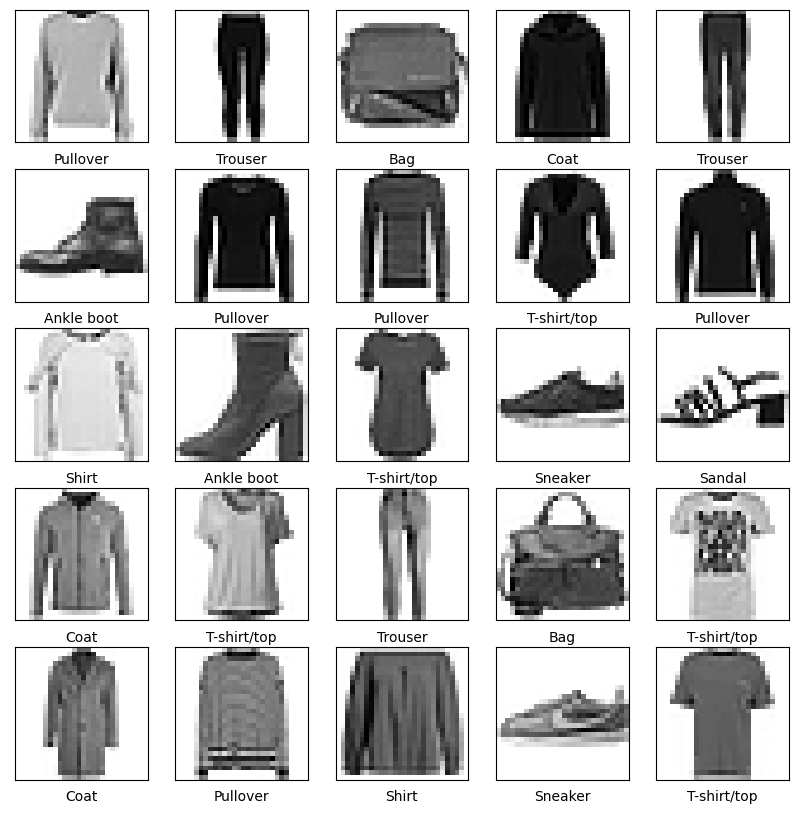

In [11]:
# Ahora graficamos 25 ejemplos más para ver cómo están categorizadas.
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

## CREATE MODEL

Creamos una red de tipo secuencial con Keras. <br>
Definimos nuestra capa de entrada manualmente  de tipo Flatten.<br>
Agregamos 5 capas ocultas densas, 2 con 50 neuronas y 3 con 100, y todas ellas con la función de activación relU.<br>
Finalmente, agregamos la capa de salida con 10 neuronas y agregamos la función de activación softmax. <br>
Esta se suele agregar en la capa de salida de los modelos de clasificación para asegurar que la suma de las salidas siempre sea igual a 1.

In [12]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #Por ser de 28x28 píxeles, y solo tiene un canal por ser las imágenes en blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

Ahora compilamos el modelo para especificar cómo se entrenará y cómo se evaluará su rendimiento.

- Se optimiza con "adam", una forma eficiente de actualizar los pesos del modelo durante su entrenamiento.
- La función de pérdida es importante porque mide la diferencia entre las predicciones del modelo y las etiquetas reales. En este caso usamos "sparse_categorical_crossentropy" porque es ideal en problemas de clasificación multiclase.
- La función de métricas es quien evaluará el rendimiento del modelo. "Accuracy" es la más clara porque mide la fracción de etiquetas prececidas correctamente.

In [13]:
#Ahora compilamos el modelo
modelo.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [15]:
#Definimos estas variables para tener el número imágenes de entrenamiento y prueba
num_ej_train = metadata.splits["train"].num_examples
num_ej_test = metadata.splits["test"].num_examples

print(num_ej_train)
print(num_ej_test)

60000
10000


In [16]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
batch_size = 32

# Shuffle y repeat sirven para que las vueltas que de el modelo en cada entrenamiento se haga en orden diferente,
# de manera aleatoria
data_train = data_train.repeat().shuffle(num_ej_train).batch(batch_size)
datos_test = data_test.batch(batch_size)

## TRAIN MODEL

In [13]:
import math

#Entrenamos el modelo usando 20 épocas.
record = modelo.fit(datos_entrenamiento, epochs=20, steps_per_epoch= math.ceil(num_ej_train/batch_size))

Epoch 1/20
1875/1875 [==============================] - 4s 1ms/step - loss: 0.5280 - accuracy: 0.8065
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3872 - accuracy: 0.8570
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3609 - accuracy: 0.8679
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3319 - accuracy: 0.8783
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3179 - accuracy: 0.8829
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3023 - accuracy: 0.8872
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2926 - accuracy: 0.8915
Epoch 8/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2810 - accuracy: 0.8957
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2752 - accuracy: 0.8977
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.269

Conseguimos una precisión de **91%**

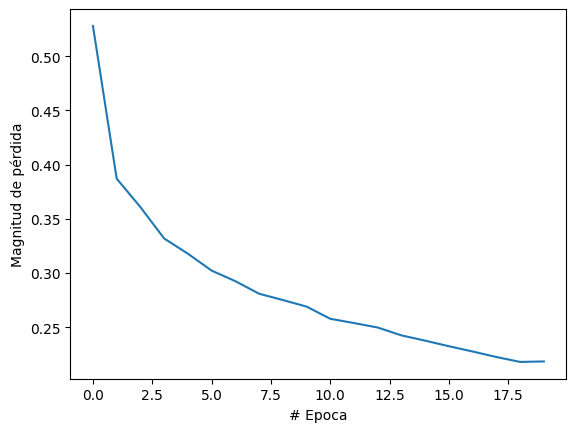

In [14]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(record.history["loss"])

Ahora vamos a imprimir 25 imágenes del conjunto de datos de pruebas, para que intente predecir uno a uno. Con barras azules y rojas veremos el éxito de la predicción. 

1/1 [==============================] - 0s 61ms/step


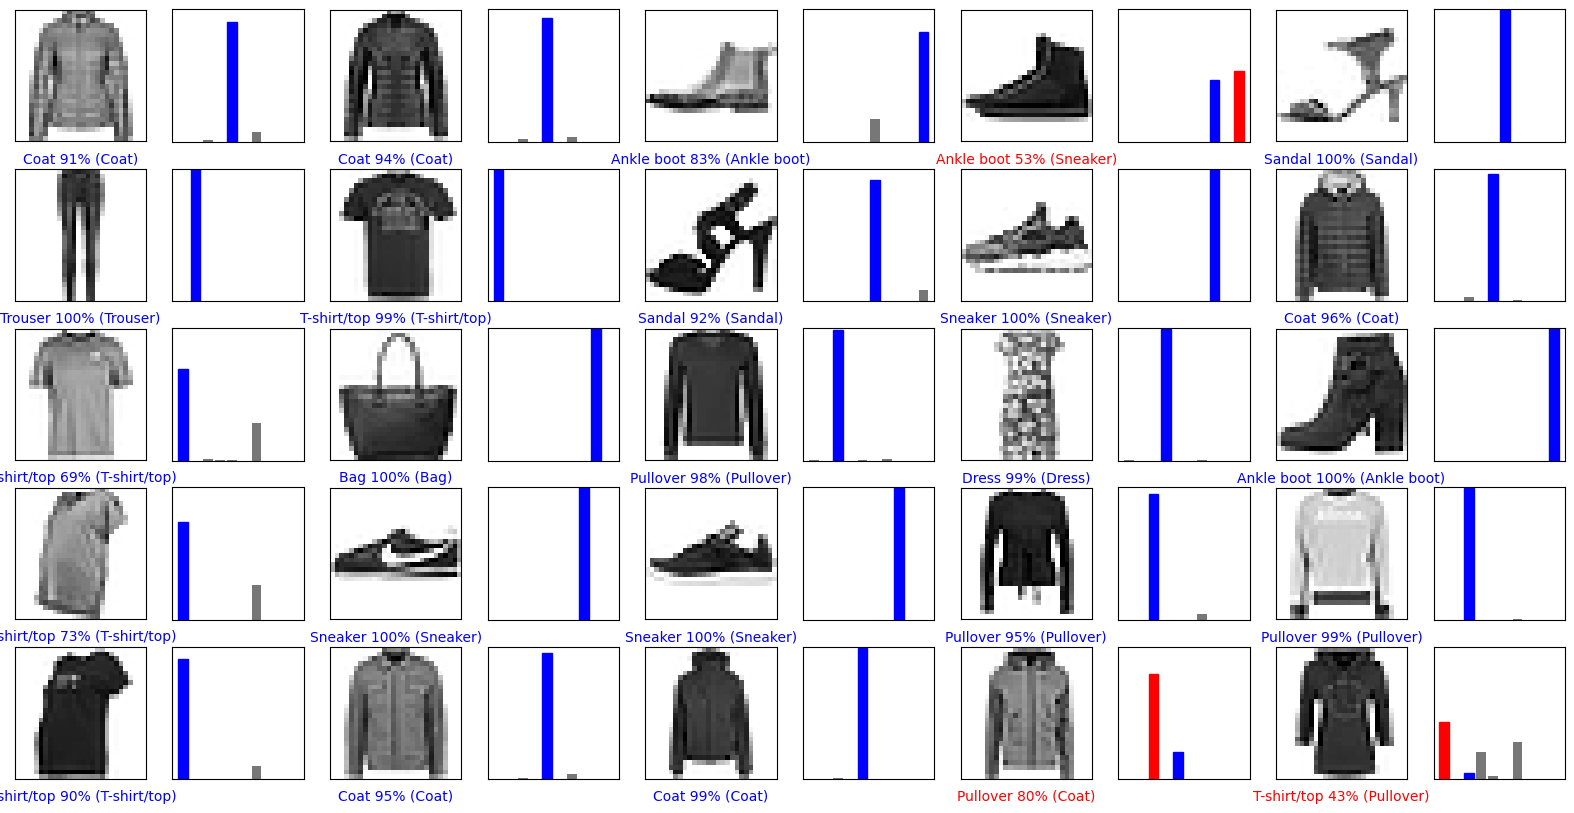

In [15]:
# Imprimos resultados con imágenes del set con matplotlib
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [17]:
# Guardo el modelo para usarlo más tarde
modelo.save("modelo_exp.h5")

In [19]:

from tensorflow.keras.models import load_model

model = load_model("modelo_exportado.h5")
tfjs.converters.save_keras_model(model, "tfjs_target_dir")